In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import yaml

plt.rcParams['text.usetex'] = True
plt.rcParams['text.latex.preamble'] = r'\usepackage{amsmath} \usepackage{amsfonts} \usepackage{amssymb}'

## Figure 1

In [17]:
import torch
from main import CustomDataset


def sample_points(embed_dim = 5000, signal_norm = 15, noise_strength = 0.05):
    train_n = 100
    test_n = 100
    T = 8
    rho = 0.2

    vmu_1 = torch.zeros(embed_dim)
    vmu_2 = torch.zeros(embed_dim)
    vmu_1[0] = signal_norm
    vmu_2[1] = signal_norm

    train_dataset = CustomDataset(train_n, T, embed_dim, vmu_1, vmu_2, rho, noise_ratio=0.2)
    test_dataset = CustomDataset(test_n, T, embed_dim, vmu_1, vmu_2, rho, noise_ratio=0.0)
    noise_component = torch.zeros(embed_dim)
    # Add noise component for each noisy training sample
    for i, is_noisy in enumerate(train_dataset.noisy_data_mask):
        if is_noisy:
            noise_component += train_dataset.data[i, 2] - rho * (vmu_1 if train_dataset.label[i] == 1 else vmu_2)
        else:
            noise_component += train_dataset.data[i, 0] - (vmu_1 if train_dataset.label[i] == 1 else vmu_2)

    def calc_attention_scores(x):
        p = (vmu_1 + vmu_2 + noise_strength * noise_component)
        attention_logits = (x @ p).squeeze(-1)
        return torch.softmax(attention_logits, dim=-1).numpy()

    # Projections to vmu_1 and vmu_2 directions. They equal to the 0-th and 1-st components of vectors.
    train_vmu_1 = []
    train_vmu_2 = []
    test_vmu_1 = []
    test_vmu_2 = []
    for x in train_dataset.data:
        attention_scores = calc_attention_scores(x)
        selected_token = x[np.argmax(attention_scores)]
        train_vmu_1.append(selected_token[0].item())
        train_vmu_2.append(selected_token[1].item())
    for x in test_dataset.data:
        attention_scores = calc_attention_scores(x)
        selected_token = x[np.argmax(attention_scores)]
        test_vmu_1.append(selected_token[0].item())
        test_vmu_2.append(selected_token[1].item())

    train_count = 0
    test_count = 0
    for i, y in enumerate(train_dataset.label):
        if (train_vmu_1[i] > train_vmu_2[i]) and y == 1:
            train_count += 1
        if (train_vmu_1[i] < train_vmu_2[i]) and y == -1:
            train_count += 1
    for i, y in enumerate(test_dataset.label):
        if (test_vmu_1[i] > test_vmu_2[i]) and y == 1:
            test_count += 1
        if (test_vmu_1[i] < test_vmu_2[i]) and y == -1:
            test_count += 1
    print(f"Train acc: {train_count / len(train_dataset.label)}, Test acc: {test_count / len(test_dataset.label)}")
    return train_vmu_1, train_vmu_2, test_vmu_1, test_vmu_2, train_dataset.label, test_dataset.label

Train acc: 1.0, Test acc: 1.0
Train acc: 1.0, Test acc: 0.58
Train acc: 0.8, Test acc: 1.0


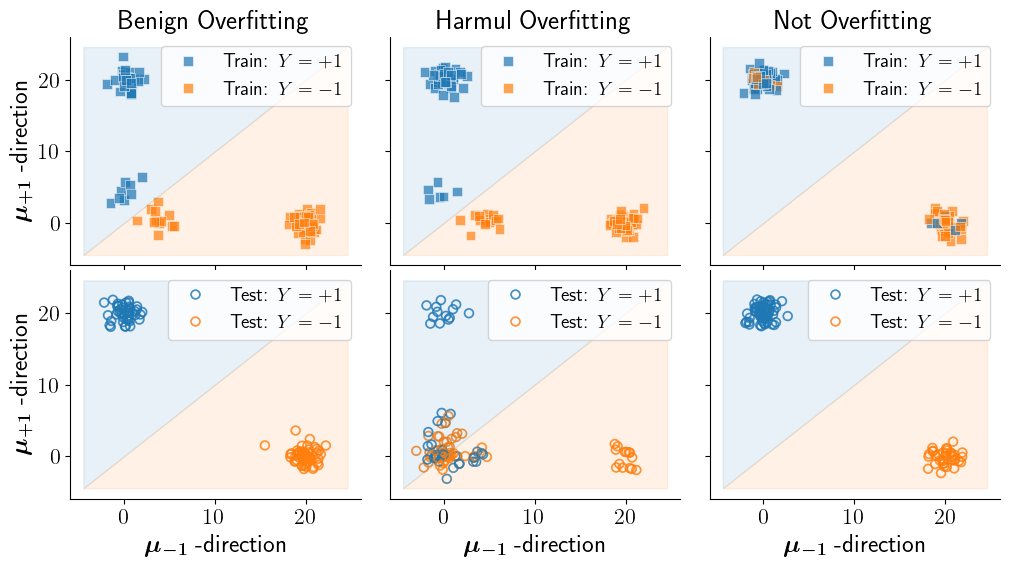

In [18]:
plt.rcParams['font.size'] = 16

fig, axs = plt.subplots(2, 3, figsize=(12, 6), sharex=True, sharey=True, gridspec_kw=dict(hspace=0.02, wspace=0.1))

train_vmu_1, train_vmu_2, test_vmu_1, test_vmu_2, train_label, test_label = sample_points(10000, 20, 0.06)
sns.scatterplot(x=test_vmu_1, y=test_vmu_2, s=50, hue=test_label, ax=axs[1][0], palette="tab10", alpha=0.7, edgecolor="face", marker="$\circ$")
sns.scatterplot(x=train_vmu_1, y=train_vmu_2, s=50, hue=train_label, ax=axs[0][0], marker='s', palette="tab10", alpha=0.7)

train_vmu_1, train_vmu_2, test_vmu_1, test_vmu_2, train_label, test_label = sample_points(10000, 20, 1)
sns.scatterplot(x=test_vmu_1, y=test_vmu_2, s=50, hue=test_label, ax=axs[1][1], palette="tab10", alpha=0.7, edgecolor="face", marker="$\circ$")
sns.scatterplot(x=train_vmu_1, y=train_vmu_2, s=50, hue=train_label, ax=axs[0][1], marker='s', palette="tab10", alpha=0.7)

train_vmu_1, train_vmu_2, test_vmu_1, test_vmu_2, train_label, test_label = sample_points(10000, 20, 0.001)
sns.scatterplot(x=test_vmu_1, y=test_vmu_2, s=50, hue=test_label, ax=axs[1][2], palette="tab10", alpha=0.7, edgecolor="face", marker="$\circ$")
sns.scatterplot(x=train_vmu_1, y=train_vmu_2, s=50, hue=train_label, ax=axs[0][2], marker='s', palette="tab10", alpha=0.7)

xyrange = (0,0)
for ax in axs.flatten():
    xyrange = (min(xyrange[0], ax.get_xlim()[0], ax.get_ylim()[0]), max(xyrange[1], ax.get_xlim()[1], ax.get_ylim()[1]))

labels = ["Train: $Y=+1$", "Train: $Y=-1$"]
for ax in axs[0]:
    h, l = ax.get_legend_handles_labels()
    ax.legend(h, labels, loc="upper right", fontsize=14)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    ax.fill_between(xyrange, xyrange, xyrange[1], color="tab:blue", alpha=0.1)
    ax.fill_between(xyrange, xyrange[0], xyrange, color="tab:orange", alpha=0.1)

labels = ["Test: $Y=+1$", "Test: $Y=-1$"]
for ax in axs[1]:
    h, l = ax.get_legend_handles_labels()
    ax.legend(h, labels, loc="upper right", fontsize=14)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    ax.fill_between(xyrange, xyrange, xyrange[1], color="tab:blue", alpha=0.1)
    ax.fill_between(xyrange, xyrange[0], xyrange, color="tab:orange", alpha=0.1)

axs[1][0].set_xlabel("$\\boldsymbol{\\mathbf{\\mu_{-1}}}$ -direction", fontsize=18)
axs[1][1].set_xlabel("$\\boldsymbol{\\mathbf{\\mu_{-1}}}$ -direction", fontsize=18)
axs[1][2].set_xlabel("$\\boldsymbol{\\mathbf{\\mu_{-1}}}$ -direction", fontsize=18)

axs[0][0].set_ylabel("$\\boldsymbol{\\mathbf{\\mu_{+1}}}$ -direction", fontsize=18)
axs[1][0].set_ylabel("$\\boldsymbol{\\mathbf{\\mu_{+1}}}$ -direction", fontsize=18)

axs[0][0].set_title("Benign Overfitting")
axs[0][1].set_title("Harmul Overfitting")
axs[0][2].set_title("Not Overfitting")

plt.show()

## Figure 3

In [2]:
plt.rcParams['font.size'] = 18

def find_matching_path_and_dict(condition) -> list[tuple[str, dict]]:
    res = []
    for dir in os.listdir("./outputs"):
        for subdir in os.listdir(os.path.join("./outputs", dir)):
            config_path = os.path.join("./outputs", dir, subdir, ".hydra/config.yaml")
            assert os.path.exists(config_path)
            with open(config_path, "r") as f:
                config = yaml.safe_load(f)
                if condition(config):
                    res.append((os.path.join("./outputs", dir, subdir), config))
    return res

### (a) Balanced Setting

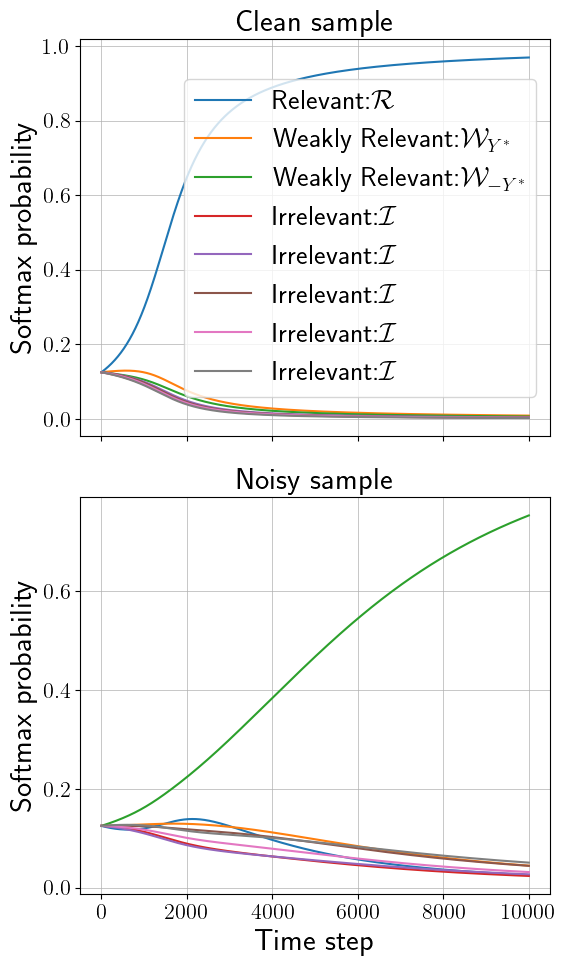

In [3]:
path = find_matching_path_and_dict(lambda x: x["embed_dim"] == 2000 and x["signal_norm"] == 20)[0][0]
df = pd.read_csv(os.path.join(path, "attention_scores.csv"))
sample_id_clean = df[df["label_flipped"] == False]["sample_id"].values[0]
sample_id_noisy = df[df["label_flipped"] == True]["sample_id"].values[0]

fig, axs = plt.subplots(2, 1, figsize=(6, 10), tight_layout=True, sharex=True)
for token_id in range(8):
    if token_id == 0:
        label = r'Relevant:$\mathcal{R}$'
    elif token_id == 1:
        label = r'Weakly Relevant:$\mathcal{W}_{Y^*}$'
    elif token_id == 2:
        label = r'Weakly Relevant:$\mathcal{W}_{-Y^*}$'
    else:
        label = r'Irrelevant:$\mathcal{I}$'
    sns.lineplot(x="time_step", y="attention_score", data=df[(df["sample_id"] == sample_id_clean) & (df["token_id"] == token_id)], ax=axs[0], label=label)
    sns.lineplot(x="time_step", y="attention_score", data=df[(df["sample_id"] == sample_id_noisy) & (df["token_id"] == token_id)], ax=axs[1])

axs[0].set_title("Clean sample", fontsize=22)
axs[1].set_title("Noisy sample", fontsize=22)

axs[0].legend(fontsize=20)

for ax in axs:
    ax.set_xlabel("Time step", fontsize=22)
    ax.set_ylabel("Softmax probability", fontsize=22)
    ax.grid(lw=0.5)
    ax.tick_params(labelsize=16)


### (b) Large Noise Setting

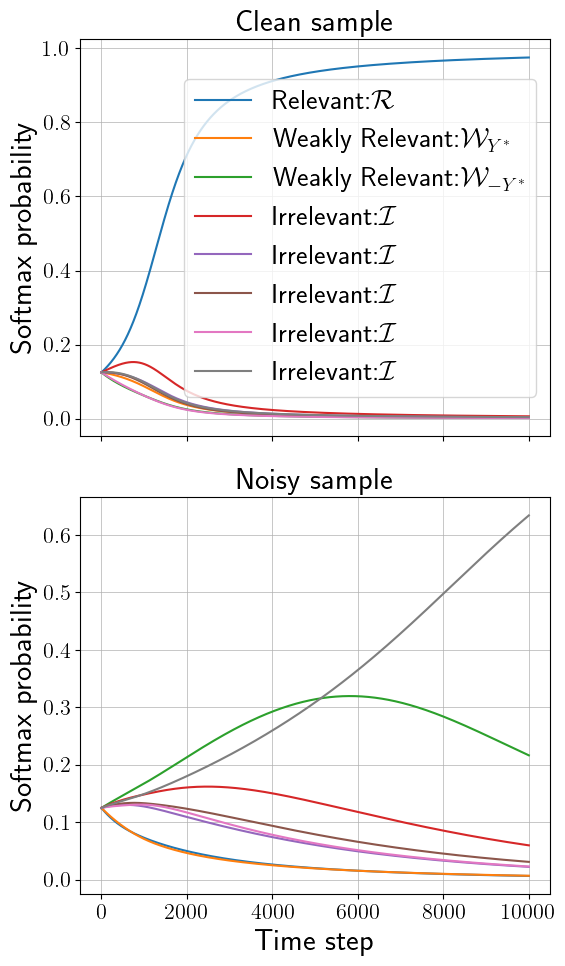

In [5]:
path = find_matching_path_and_dict(lambda x: x["embed_dim"] == 4500 and x["signal_norm"] == 5)[0][0]
df = pd.read_csv(os.path.join(path, "attention_scores.csv"))
sample_id_clean = df[df["label_flipped"] == False]["sample_id"].values[0]
sample_id_noisy = df[df["label_flipped"] == True]["sample_id"].values[1]

plt.rcParams['text.usetex'] = True
plt.rcParams['font.size'] = 18

fig, axs = plt.subplots(2, 1, figsize=(6, 10), tight_layout=True, sharex=True)
for token_id in range(8):
    if token_id == 0:
        label = r'Relevant:$\mathcal{R}$'
    elif token_id == 1:
        label = r'Weakly Relevant:$\mathcal{W}_{Y^*}$'
    elif token_id == 2:
        label = r'Weakly Relevant:$\mathcal{W}_{-Y^*}$'
    else:
        label = r'Irrelevant:$\mathcal{I}$'
    sns.lineplot(x="time_step", y="attention_score", data=df[(df["sample_id"] == sample_id_clean) & (df["token_id"] == token_id)], ax=axs[0], label=label)
    sns.lineplot(x="time_step", y="attention_score", data=df[(df["sample_id"] == sample_id_noisy) & (df["token_id"] == token_id)], ax=axs[1])

axs[0].set_title("Clean sample", fontsize=22)
axs[1].set_title("Noisy sample", fontsize=22)

axs[0].legend(fontsize=20)

for ax in axs:
    ax.set_xlabel("Time step", fontsize=22)
    ax.set_ylabel("Softmax probability", fontsize=22)
    ax.grid(lw=0.5)
    ax.tick_params(labelsize=16)

### (c) Large Signal Setting

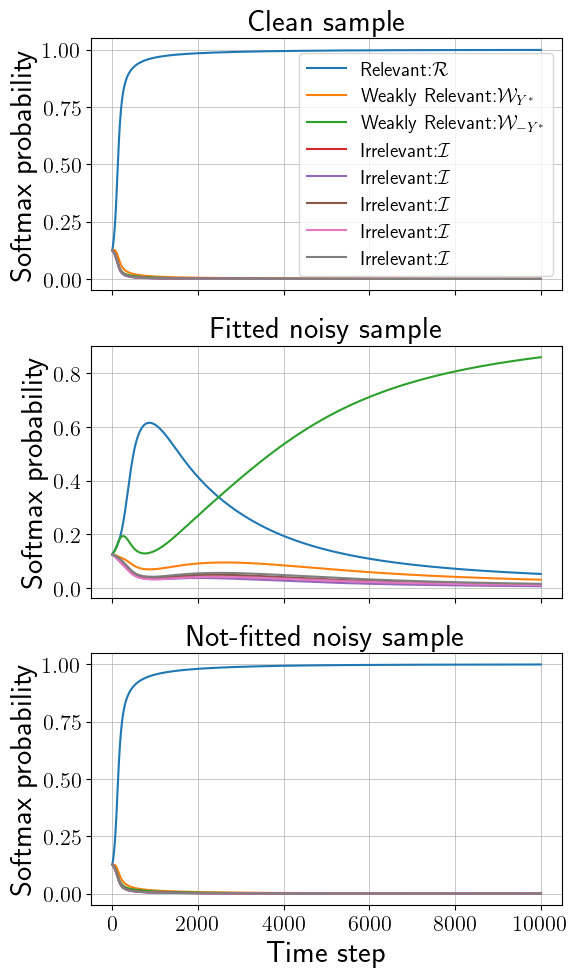

In [4]:
path = find_matching_path_and_dict(lambda x: x["embed_dim"] == 1000 and x["signal_norm"] == 80)[0][0]
df = pd.read_csv(os.path.join(path, "attention_scores.csv"))
sample_id_clean = df[df["label_flipped"] == False]["sample_id"].values[0]
sample_id_noisy = df[df["label_flipped"] == True]["sample_id"].values[0]
sample_id_noisy_1 = df[df["label_flipped"] == True]["sample_id"].values[8]

plt.rcParams['text.usetex'] = True
plt.rcParams['font.size'] = 14

fig, axs = plt.subplots(3, 1, figsize=(6, 10), tight_layout=True, sharex=True)
for token_id in range(8):
    if token_id == 0:
        label = r'Relevant:$\mathcal{R}$'
    elif token_id == 1:
        label = r'Weakly Relevant:$\mathcal{W}_{Y^*}$'
    elif token_id == 2:
        label = r'Weakly Relevant:$\mathcal{W}_{-Y^*}$'
    else:
        label = r'Irrelevant:$\mathcal{I}$'
    sns.lineplot(x="time_step", y="attention_score", data=df[(df["sample_id"] == sample_id_clean) & (df["token_id"] == token_id)], ax=axs[0], label=label)
    sns.lineplot(x="time_step", y="attention_score", data=df[(df["sample_id"] == sample_id_noisy_1) & (df["token_id"] == token_id)], ax=axs[1])
    sns.lineplot(x="time_step", y="attention_score", data=df[(df["sample_id"] == sample_id_noisy) & (df["token_id"] == token_id)], ax=axs[2])

axs[0].set_title("Clean sample", fontsize=22)
axs[1].set_title("Fitted noisy sample", fontsize=22)
axs[2].set_title("Not-fitted noisy sample", fontsize=22)

axs[0].legend(fontsize=14)

for ax in axs:
    ax.set_xlabel("Time step", fontsize=22)
    ax.set_ylabel("Softmax probability", fontsize=22)
    ax.grid(lw=0.5)
    ax.tick_params(labelsize=16)

## Figure 4

In [6]:
embed_dim_list = [250, 500, 750, 1000, 1250, 1500, 1750, 2000, 2250, 2500, 2750, 3000, 3250, 3500, 3750, 4000, 4250, 4500, 4750, 5000]
signal_norm_list = [5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100]

res = {}
for dir in os.listdir("./multirun"):
    for subdir in os.listdir(os.path.join("./multirun", dir)):
        for ssubdir in os.listdir(os.path.join("./multirun", dir, subdir)):
            if not os.path.isdir(os.path.join("./multirun", dir, subdir, ssubdir)):
                continue
            config_path = os.path.join("./multirun", dir, subdir, ssubdir, ".hydra/config.yaml")
            assert os.path.exists(config_path), "{} does not exist".format(config_path)
            with open(config_path, "r") as f:
                config = yaml.safe_load(f)
            key = (config["embed_dim"], config["signal_norm"])
            if key[0] not in embed_dim_list or key[1] not in signal_norm_list:
                continue

            with open(os.path.join("./multirun", dir, subdir, ssubdir, "stats_time_step.csv"), "r") as f:
                df = pd.read_csv(f)
            res[key] = {
                "mathfrak_s_1": df["mathfrak_s_1"].values[-1],
                "mathfrak_s_2": df["mathfrak_s_2"].values[-1]
            }

            with open(os.path.join("./multirun", dir, subdir, ssubdir, "attention_scores.csv"), "r") as f:
                df = pd.read_csv(f)
            res[key]["max_cumulative_attention"] = df.groupby("time_step", as_index=False)["cumulative_attention"].max()["cumulative_attention"].values[-1]

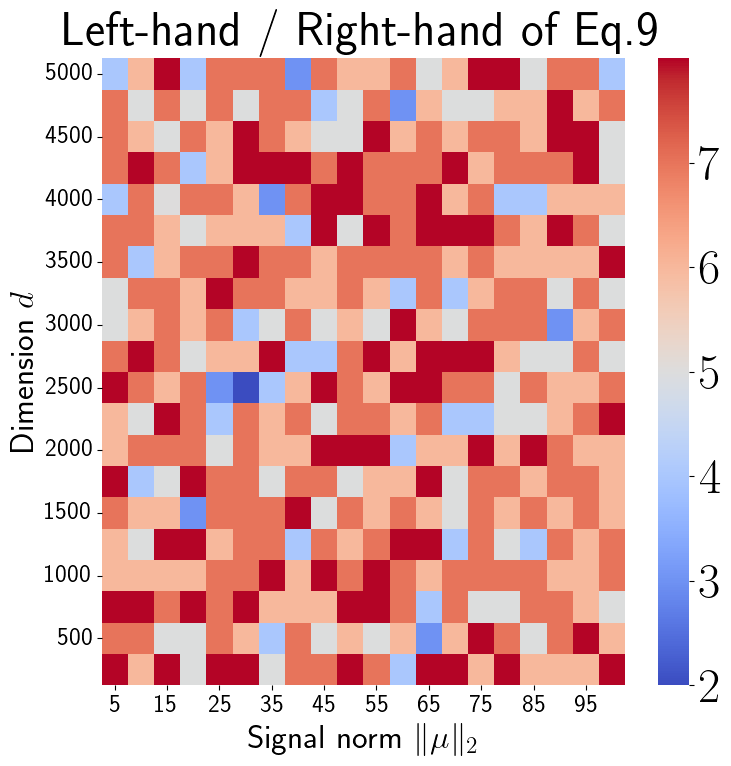

In [7]:
arr_2d = np.zeros((20, 20))

for i, ed in enumerate(embed_dim_list):
    for j, sn in enumerate(signal_norm_list):
        arr_2d[i, j] = min(res[(ed, sn)]["mathfrak_s_1"], res[(ed, sn)]["mathfrak_s_2"]) / res[(ed, sn)]["max_cumulative_attention"]

df = pd.DataFrame(arr_2d, columns=signal_norm_list, index=embed_dim_list)
fig, ax = plt.subplots(1, 1, figsize=(8, 8), tight_layout=True)
sns.heatmap(df, ax=ax, cmap="coolwarm", annot_kws={"fontsize": 8})

ax.invert_yaxis()
current_yticks = ax.get_yticks()
ax.set_yticks(current_yticks[1::2])

ax.set_xlabel("Signal norm $\|\mathbf{\mu}\|_2$", fontsize=24)
ax.set_ylabel("Dimension $d$", fontsize=24)

cbar = ax.collections[0].colorbar
cbar.ax.tick_params(labelsize=35)

ax.set_title("Left-hand / Right-hand of Eq.9", fontsize=35)
plt.show()

## Figure 5

In [8]:
embed_dim_list = [250, 500, 750, 1000, 1250, 1500, 1750, 2000, 2250, 2500, 2750, 3000, 3250, 3500, 3750, 4000, 4250, 4500, 4750, 5000]
signal_norm_list = [5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100]

res_loss = {}
for dir in os.listdir("./multirun"):
    for subdir in os.listdir(os.path.join("./multirun", dir)):
        for ssubdir in os.listdir(os.path.join("./multirun", dir, subdir)):
            if not os.path.isdir(os.path.join("./multirun", dir, subdir, ssubdir)):
                continue
            config_path = os.path.join("./multirun", dir, subdir, ssubdir, ".hydra/config.yaml")
            assert os.path.exists(config_path), "{} does not exist".format(config_path)
            with open(config_path, "r") as f:
                config = yaml.safe_load(f)
            key = (config["embed_dim"], config["signal_norm"])

            with open(os.path.join("./multirun", dir, subdir, ssubdir, "stats_time_step.csv"), "r") as f:
                df = pd.read_csv(f)
            res_loss[key] = {
                "train_loss": df["train_loss"].values[-1],
                "test_loss": df["test_loss"].values[-1]
            }

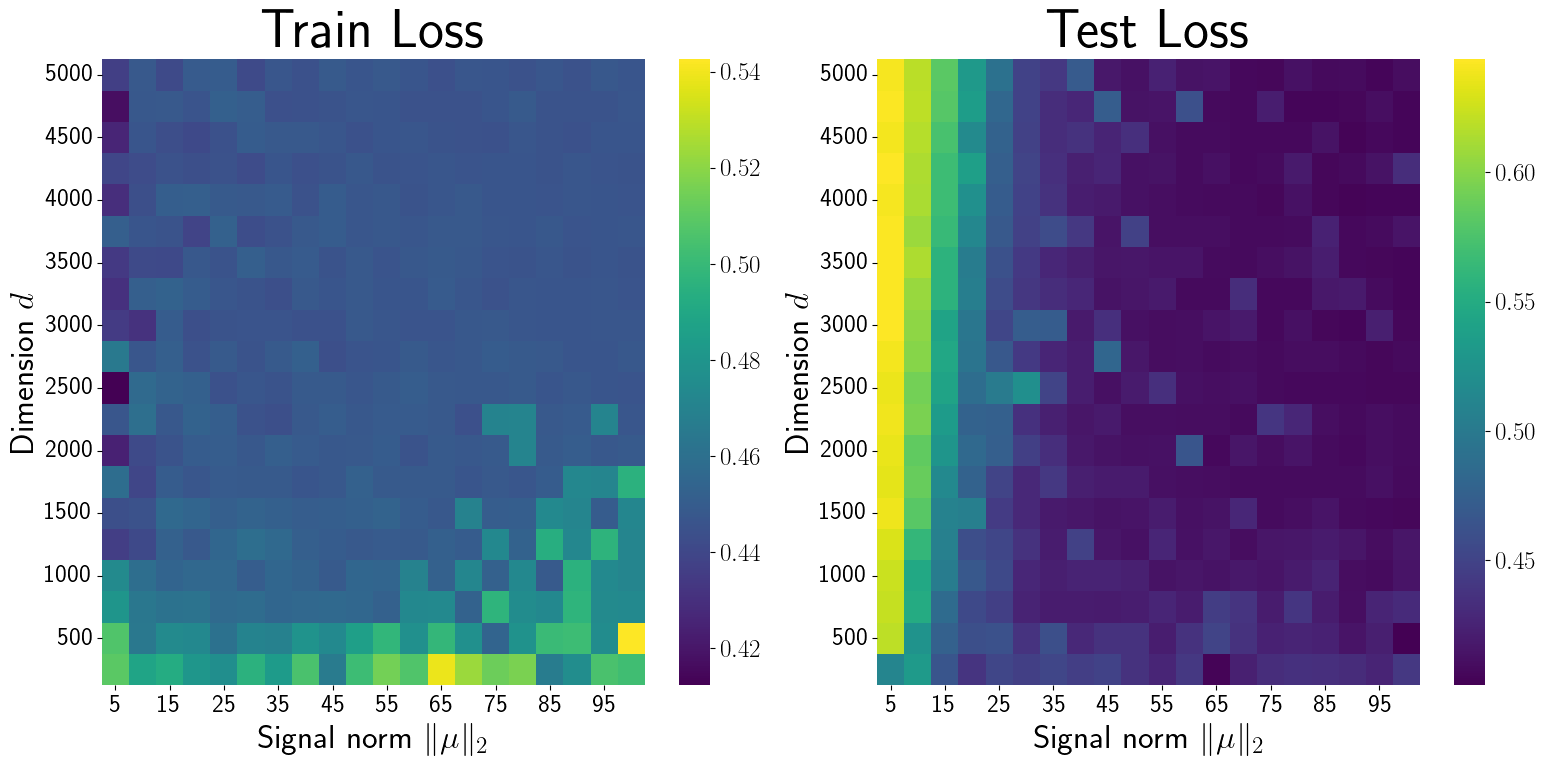

In [9]:
arr_2d_train_loss = np.zeros((20, 20))
arr_2d_test_loss = np.zeros((20, 20))

for i, ed in enumerate(embed_dim_list):
    for j, sn in enumerate(signal_norm_list):
        arr_2d_train_loss[i, j] = res_loss[(ed, sn)]["train_loss"]
        arr_2d_test_loss[i, j] = res_loss[(ed, sn)]["test_loss"]

df_train_loss = pd.DataFrame(arr_2d_train_loss, columns=signal_norm_list, index=embed_dim_list)
df_test_loss = pd.DataFrame(arr_2d_test_loss, columns=signal_norm_list, index=embed_dim_list)
fig, axs = plt.subplots(1, 2, figsize=(16, 8), tight_layout=True)
sns.heatmap(df_train_loss, fmt=".2f", ax=axs[0], cmap="viridis")
sns.heatmap(df_test_loss, fmt=".2f", ax=axs[1], cmap="viridis")

axs[1].set_xticks(axs[0].get_xticks())
axs[1].set_xticklabels(axs[0].get_xticklabels(), rotation=360)
for ax in axs:
    ax.invert_yaxis()
    current_yticks = ax.get_yticks()
    ax.set_yticks(current_yticks[1::2])

    ax.set_xlabel("Signal norm $\|\mathbf{\mu}\|_2$", fontsize=24)
    ax.set_ylabel("Dimension $d$", fontsize=24)

axs[0].set_title("Train Loss", fontsize=40)
axs[1].set_title("Test Loss", fontsize=40)
plt.show()

## Figure 6

In [10]:
embed_dim_list = [250, 500, 750, 1000, 1250, 1500, 1750, 2000, 2250, 2500, 2750, 3000, 3250, 3500, 3750, 4000, 4250, 4500, 4750, 5000]
signal_norm_list = [5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100]

res_class = {}
for dir in os.listdir("./multirun"):
    for subdir in os.listdir(os.path.join("./multirun", dir)):
        for ssubdir in os.listdir(os.path.join("./multirun", dir, subdir)):
            if not os.path.isdir(os.path.join("./multirun", dir, subdir, ssubdir)):
                continue
            config_path = os.path.join("./multirun", dir, subdir, ssubdir, ".hydra/config.yaml")
            assert os.path.exists(config_path), "{} does not exist".format(config_path)
            with open(config_path, "r") as f:
                config = yaml.safe_load(f)
            key = (config["embed_dim"], config["signal_norm"])
            if key[0] not in embed_dim_list or key[1] not in signal_norm_list:
                continue

            with open(os.path.join("./multirun", dir, subdir, ssubdir, "stats_time_step.csv"), "r") as f:
                df = pd.read_csv(f)
            res_class[key] = {
                "mathfrak_s_1_0": df["mathfrak_s_1"].values[0],
                "mathfrak_s_2_0": df["mathfrak_s_2"].values[0],
                "mathfrak_s_1": df["mathfrak_s_1"].values[-1],
                "mathfrak_s_2": df["mathfrak_s_2"].values[-1],
            }

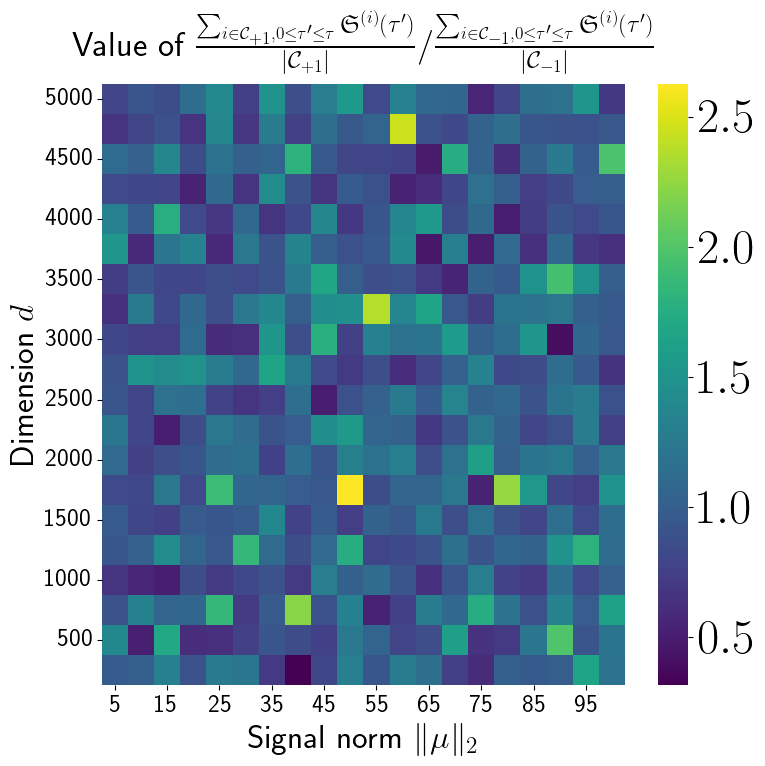

In [11]:
arr_2d = np.zeros((20, 20))

for i, ed in enumerate(embed_dim_list):
    for j, sn in enumerate(signal_norm_list):
        arr_2d[i, j] = (res_class[(ed, sn)]["mathfrak_s_1"] / res_class[(ed, sn)]["mathfrak_s_2"]) / (res_class[(ed, sn)]["mathfrak_s_1_0"] / res_class[(ed, sn)]["mathfrak_s_2_0"])

df = pd.DataFrame(arr_2d, columns=signal_norm_list, index=embed_dim_list)

fig, ax = plt.subplots(1, 1, figsize=(8, 8), tight_layout=True)
sns.heatmap(df, fmt=".2f", ax=ax, cmap="viridis")

ax.invert_yaxis()
current_yticks = ax.get_yticks()
ax.set_yticks(current_yticks[1::2])

ax.set_xlabel("Signal norm $\|\mathbf{\mu}\|_2$", fontsize=24)
ax.set_ylabel("Dimension $d$", fontsize=24)

cbar = ax.collections[0].colorbar
cbar.ax.tick_params(labelsize=35)

ax.set_title("Value of $\\frac{\sum_{i\in\mathcal{C}_{+1}, 0\leq\\tau^\prime \leq\\tau} \mathfrak{S}^{(i)}(\\tau^\prime)}{|\mathcal{C}_{+1}|} / \\frac{\sum_{i\in\mathcal{C}_{-1}, 0\leq\\tau^\prime \leq\\tau} \mathfrak{S}^{(i)}(\\tau^\prime)}{|\mathcal{C}_{-1}|}$", fontsize=25, pad=20)
plt.show()